<a href="https://colab.research.google.com/github/Sai230803/Hospital_Readmission_prediction-/blob/main/hospital_Readmission_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Loading & Engineering Functions**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
# 1. Load Data and dropping duplicate rows in training dataset
train_raw = pd.read_csv('/content/Train-1617360447408-1660719685476.csv')
test_raw = pd.read_csv('/content/test-1617360461595-1660719701431.csv')

print(f"   Original Train Rows: {len(train_raw)}")
train_raw = train_raw.drop_duplicates(subset=['encounter_id'])
print(f"   Rows after removing duplicates: {len(train_raw)}")

   Original Train Rows: 66587
   Rows after removing duplicates: 48911


In [3]:
train_raw.head()

,index,encounter_id,patient_id,race,gender,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,...,X19,X20,X21,X22,X23,X24,X25,change,diabetesMed,readmitted
0,69375,197029140,51521940,Hispanic,Male,[80-90),?,4,Emergency/Trauma,39,...,No,No,No,No,No,No,No,No,Yes,1
1,57272,163571946,92631357,Caucasian,Male,[60-70),?,3,Emergency/Trauma,34,...,No,No,No,No,No,No,No,No,No,0
2,82347,256497366,30023982,Caucasian,Female,[50-60),?,6,Nephrology,50,...,No,Down,No,No,No,No,No,Ch,Yes,1
3,89608,289891212,93606021,AfricanAmerican,Female,[70-80),?,5,?,63,...,No,Down,No,No,No,No,No,Ch,Yes,1
4,24091,81873900,23464296,Caucasian,Male,[70-80),?,9,Psychiatry,17,...,No,No,No,No,No,No,No,No,No,1


# --- HELPER FUNCTIONS ---


In [4]:
def process_age(age_str):
    """Converts age intervals '[0-10)' to numeric 5, 15, etc."""
    if pd.isna(age_str) or age_str == '?': return -1
    age_map = {
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }
    return age_map.get(age_str, -1)

In [5]:
def map_diagnosis(code):
    """Maps 900+ ICD-9 codes to 9 Clinical Categories (Crucial Step)"""
    s_code = str(code)
    if s_code.startswith('V') or s_code.startswith('E') or code == '?': return 'Other'

    try:
        n = float(code)
    except:
        return 'Other'

    if 390 <= n <= 459 or n == 785: return 'Circulatory'
    if 460 <= n <= 519 or n == 786: return 'Respiratory'
    if 520 <= n <= 579 or n == 787: return 'Digestive'
    if 250 <= n < 251: return 'Diabetes'
    if 800 <= n <= 999: return 'Injury'
    if 710 <= n <= 739: return 'Musculoskeletal'
    if 580 <= n <= 629 or n == 788: return 'Genitourinary'
    if 140 <= n <= 239: return 'Neoplasms'
    return 'Other'

In [6]:
def clean_and_engineer(df, is_train=True):
    """Full Pipeline: Cleans data and creates new features"""
    df = df.copy()
    df.replace('?', np.nan, inplace=True)

    # 1. Store IDs for submission (only for test data) if needed later
    # We generally drop them for modeling
    drop_cols = ['weight', 'payer_code', 'encounter_id', 'patient_id', 'index']
    for c in drop_cols:
        if c in df.columns: df.drop(c, axis=1, inplace=True)

    # 2. Fill Missing Values
    df['race'].fillna('Other', inplace=True)
    df['gender'].fillna('Unknown', inplace=True)

    # 3. Feature Engineering
    # A. Age
    df['age_num'] = df['age'].apply(process_age)
    df.drop('age', axis=1, inplace=True)

    # B. Service Utilization (Total history)
    df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

    # C. Diagnosis Grouping (Apply to ALL 5 columns)
    diag_cols = ['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5']
    for col in diag_cols:
        df[f'{col}_cat'] = df[col].apply(map_diagnosis)

    # D. Specific Disease Flags
    # Create a flag if the patient has Diabetes in ANY of the 5 diagnosis slots
    df['has_diabetes_diag'] = df[[f'{c}_cat' for c in diag_cols]].apply(
        lambda row: 1 if 'Diabetes' in row.values else 0, axis=1)

    # E. Medication Count & Changes
    # (Cols X3..X25 are medications)
    med_cols = [c for c in df.columns if c.startswith('X') and c not in ['X1', 'X2']]
    df['num_med_changes'] = df[med_cols].apply(lambda x: x.isin(['Up', 'Down']).sum(), axis=1)
    df['num_meds_active'] = df[med_cols].apply(lambda x: (x != 'No').sum(), axis=1)

    # F. Interaction (Severity)
    df['severity_score'] = df['time_in_hospital'] * df['num_procedures']

    # G. Medical Specialty (Keep top 10, group rest)
    top_10 = ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics',
              'Orthopedics-Reconstructive', 'Radiologist']
    df['med_spec_grouped'] = df['medical_specialty'].apply(lambda x: x if x in top_10 else 'Other')
    df.drop('medical_specialty', axis=1, inplace=True)

    # 4. Cleanup: Drop raw columns we processed
    df.drop(diag_cols + med_cols + ['X1', 'X2'], axis=1, inplace=True)

    return df

print("Functions defined successfully!")

Functions defined successfully!


#Process and Vizualize

Processing Train Data...


/tmp/ipython-input-3898999312.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna('Other', inplace=True)
/tmp/ipython-input-3898999312.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Processing Test Data...


/tmp/ipython-input-3898999312.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna('Other', inplace=True)
/tmp/ipython-input-3898999312.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

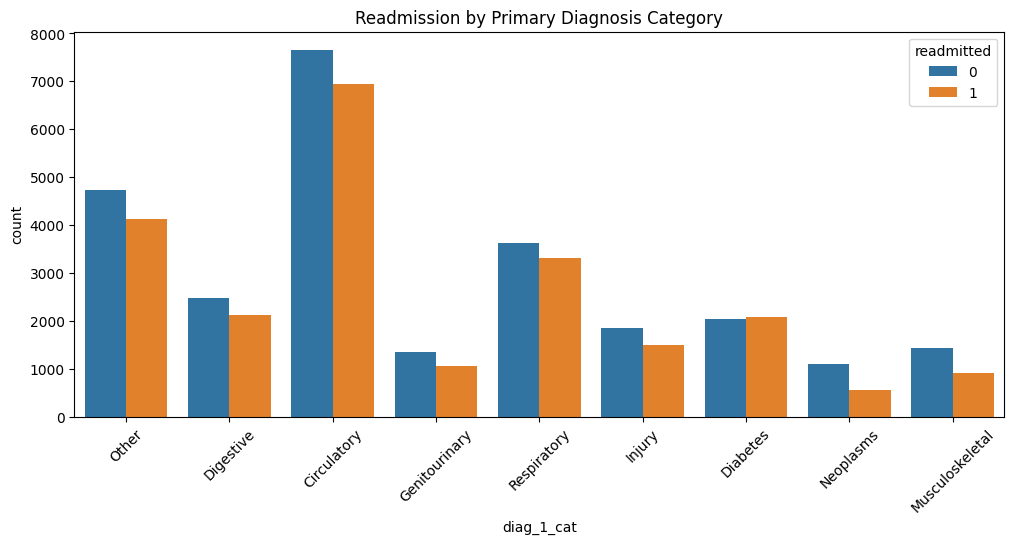

Data Shape: (48911, 25)
New Features: ['diag_1_cat', 'diag_2_cat', 'diag_3_cat', 'diag_4_cat', 'diag_5_cat', 'has_diabetes_diag', 'num_med_changes', 'num_meds_active', 'severity_score', 'med_spec_grouped']


In [7]:
# 1. Process Data
print("Processing Train Data...")
train_df = clean_and_engineer(train_raw, is_train=True)
print("Processing Test Data...")
test_df = clean_and_engineer(test_raw, is_train=False)

# 2. EDA: Visualizing Readmission by Diagnosis
# We look at the primary diagnosis (diag_1_cat)
plt.figure(figsize=(12, 5))
sns.countplot(x='diag_1_cat', hue='readmitted', data=train_df)
plt.title("Readmission by Primary Diagnosis Category")
plt.xticks(rotation=45)
plt.show()

print("Data Shape:", train_df.shape)
print("New Features:", train_df.columns[-10:].tolist())

#**Execution & EDA**

In [8]:
def clean_and_engineer(df, is_train=True):
    """Full Pipeline: Cleans data and creates new features (Pandas Warning Fixed)"""
    df = df.copy()

    # Fix: Use assignment instead of inplace=True for replace
    df = df.replace('?', np.nan)

    # 1. Drop IDs and unnecessary columns
    drop_cols = ['weight', 'payer_code', 'encounter_id', 'patient_id', 'index']
    # Only drop columns that actually exist in the dataframe
    cols_to_drop = [c for c in drop_cols if c in df.columns]
    df = df.drop(columns=cols_to_drop)

    # 2. Fill Missing Values
    # FIX: Assign the filled series back to the column instead of using inplace=True
    if 'race' in df.columns:
        df['race'] = df['race'].fillna('Other')
    if 'gender' in df.columns:
        df['gender'] = df['gender'].fillna('Unknown')

    # 3. Feature Engineering
    # A. Age
    if 'age' in df.columns:
        df['age_num'] = df['age'].apply(process_age)
        df = df.drop(columns=['age'])

    # B. Service Utilization (Total history)
    df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

    # C. Diagnosis Grouping (Apply to ALL 5 columns)
    diag_cols = ['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5']
    for col in diag_cols:
        if col in df.columns:
            df[f'{col}_cat'] = df[col].apply(map_diagnosis)

    # D. Specific Disease Flags
    # Create a flag if the patient has Diabetes in ANY of the diagnosis slots
    # We gather the category columns we just created
    cat_cols = [f'{c}_cat' for c in diag_cols if f'{c}_cat' in df.columns]
    if cat_cols:
        df['has_diabetes_diag'] = df[cat_cols].apply(
            lambda row: 1 if 'Diabetes' in row.values else 0, axis=1)

    # E. Medication Count & Changes
    # (Cols X3..X25 are medications)
    med_cols = [c for c in df.columns if c.startswith('X') and c not in ['X1', 'X2']]
    if med_cols:
        df['num_med_changes'] = df[med_cols].apply(lambda x: x.isin(['Up', 'Down']).sum(), axis=1)
        df['num_meds_active'] = df[med_cols].apply(lambda x: (x != 'No').sum(), axis=1)

    # F. Interaction (Severity)
    if 'time_in_hospital' in df.columns and 'num_procedures' in df.columns:
        df['severity_score'] = df['time_in_hospital'] * df['num_procedures']

    # G. Medical Specialty (Keep top 10, group rest)
    if 'medical_specialty' in df.columns:
        top_10 = ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                  'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics',
                  'Orthopedics-Reconstructive', 'Radiologist']
        df['med_spec_grouped'] = df['medical_specialty'].apply(lambda x: x if x in top_10 else 'Other')
        df = df.drop(columns=['medical_specialty'])

    # 4. Cleanup: Drop raw columns we processed
    # Identify which columns to drop that currently exist in df
    cols_to_remove = [c for c in diag_cols + med_cols + ['X1', 'X2'] if c in df.columns]
    df = df.drop(columns=cols_to_remove)

    return df

#**TRAINING & TUNING**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# --- 1. Encoding (One-Hot) ---
# We define which columns are categorical
cat_cols = ['race', 'gender', 'med_spec_grouped', 'change', 'diabetesMed'] + \
           [f'diag_{i}_cat' for i in range(1, 6)]

# Combine train/test for consistent encoding (standard trick to avoid column mismatches)
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['readmitted'] = 0 # Placeholder for the test set

combined = pd.concat([train_df, test_df], axis=0)
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into Train and Test
X_train_full = combined[combined['is_train'] == 1].drop(['readmitted', 'is_train'], axis=1)
y_train_full = combined[combined['is_train'] == 1]['readmitted']
X_test_final = combined[combined['is_train'] == 0].drop(['readmitted', 'is_train'], axis=1)

# --- 2. Train/Val Split ---
# We split our training data: 80% to train, 20% to validate our score
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# --- 3. Train Model ---
print("Training Gradient Boosting Model...")
clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# --- 4. Find Best Threshold ---
# Get probability predictions (e.g., 0.34, 0.88) instead of hard 0/1
val_probs = clf.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.2, 0.6, 0.05)
best_f1 = 0
best_thresh = 0.5

print("\n--- Threshold Tuning Results ---")
print(f"{'Threshold':<10} {'F1 Score':<10}")
print("-" * 35)

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = t
    print(f"{t:.2f}       {score:.4f}")

print("-" * 35)
print(f" Best Threshold found: {best_thresh:.2f}")
print(f" Max Validation F1 Score: {best_f1:.4f}")

# Final Report using the Best Threshold
final_val_preds = (val_probs >= best_thresh).astype(int)
print("\nClassification Report (Optimized):")
print(classification_report(y_val, final_val_preds))

Training Gradient Boosting Model...

--- Threshold Tuning Results ---
Threshold  F1 Score  
-----------------------------------
0.20       0.6358
0.25       0.6404
0.30       0.6402
0.35       0.6357
0.40       0.6274
0.45       0.5985
0.50       0.5448
0.55       0.4930
-----------------------------------
 Best Threshold found: 0.25
 Max Validation F1 Score: 0.6404

Classification Report (Optimized):
              precision    recall  f1-score   support

           0       0.76      0.10      0.18      5261
           1       0.48      0.96      0.64      4522

    accuracy                           0.50      9783
   macro avg       0.62      0.53      0.41      9783
weighted avg       0.63      0.50      0.39      9783



In [10]:
import sys
# Install necessary packages if they are missing
try:
    import perpetual
    import xgboost
except ImportError:
    print("Installing Perpetual ML & XGBoost...")
    !pip install -q perpetual xgboost
    import perpetual
    import xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from perpetual import PerpetualBooster
import numpy as np

# We need to scale data for Logistic Regression
# Tree models (RF, XGB, GBM, Perpetual) usually don't need scaling, but it doesn't hurt.
print("Scaling Data for linear models...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.1, eval_metric='logloss', random_state=42),

    # FIX: Move 'budget' here instead of in .fit()
    "Perpetual Boosting": PerpetualBooster(objective="LogLoss")
}

print("\n Starting Model Comparison (All 5 Models)...")
print(f"{'Model':<25} {'F1 Score':<10} {'Accuracy':<10}")
print("-" * 55)

results = {}

for name, model in models.items():
    # --- Training ---
    # Use scaled data ONLY for Logistic Regression
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_val_scaled)[:, 1]
    else:
        # For Perpetual, RF, XGB, GBM -> Just fit normally
        # Note: If Perpetual throws an error on 'budget' in init, we rely on its default.
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]

    # --- Threshold Tuning ---
    # Find the best threshold for this specific model
    best_f1 = 0
    best_t = 0.5
    for t in np.arange(0.2, 0.6, 0.05):
        score = f1_score(y_val, (probs >= t).astype(int))
        if score > best_f1:
            best_f1 = score
            best_t = t

    results[name] = {"model": model, "best_thresh": best_t, "f1": best_f1}

    # Calculate Accuracy at best threshold
    acc = (y_val == (probs >= best_t).astype(int)).mean()
    print(f"{name:<25} {best_f1:.4f}     {acc:.4f}  (Thresh: {best_t:.2f})")

print("-" * 55)

# Select the winner
winner = max(results, key=lambda x: results[x]['f1'])
print(f"\n The Winner is: {winner} with F1: {results[winner]['f1']:.4f}")

Installing Perpetual ML & XGBoost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.9/832.9 kB 34.6 MB/s eta 0:00:00
Scaling Data for linear models...

 Starting Model Comparison (All 5 Models)...
Model                     F1 Score   Accuracy  
-------------------------------------------------------
Logistic Regression       0.6395     0.5128  (Thresh: 0.35)
Random Forest             0.6397     0.5422  (Thresh: 0.35)
Gradient Boosting         0.6404     0.5007  (Thresh: 0.25)
XGBoost                   0.6426     0.5292  (Thresh: 0.30)
Perpetual Boosting        0.6380     0.5080  (Thresh: 0.25)
-------------------------------------------------------

 The Winner is: XGBoost with F1: 0.6426


#Plotting Confusion Matrix for each model

Regenerating probabilities for the plots...
 Top 4 Models: ['XGBoost', 'Gradient Boosting', 'Random Forest', 'Logistic Regression']


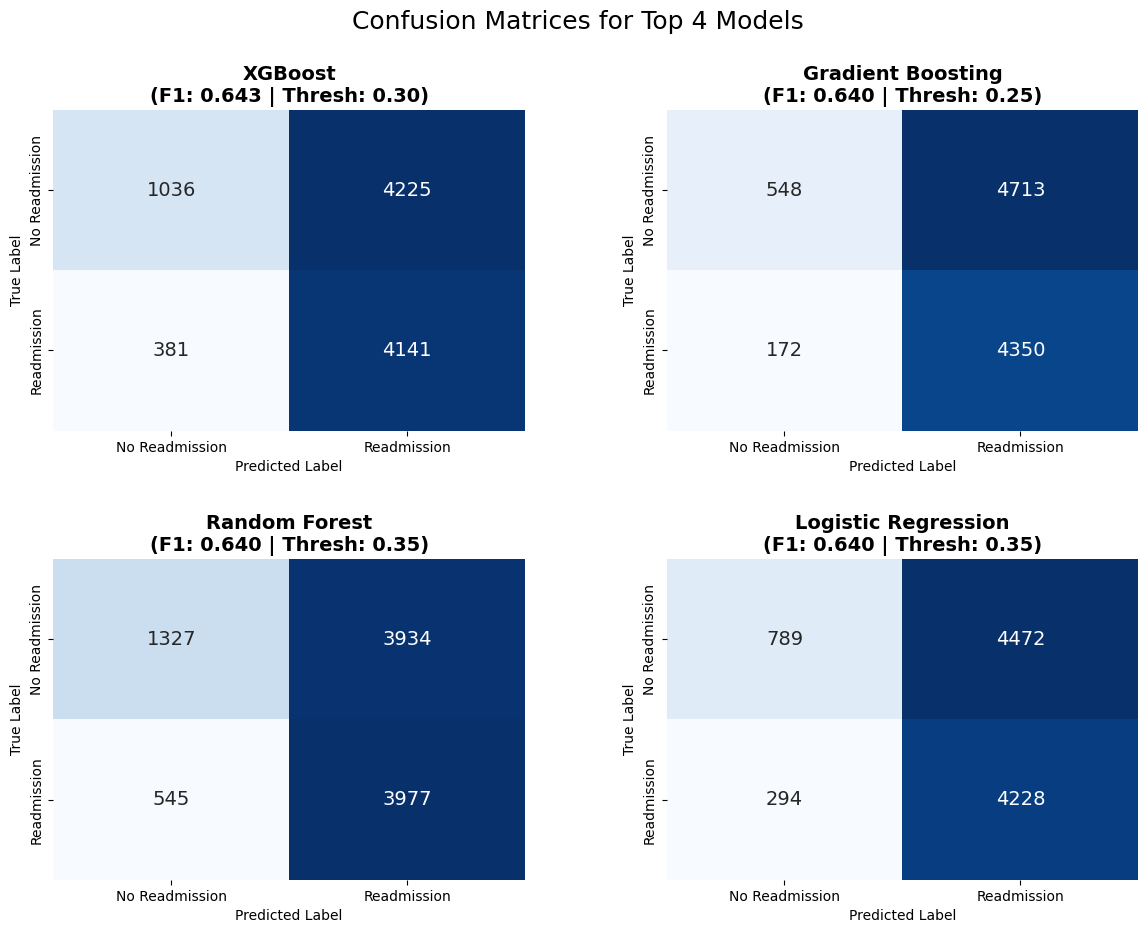

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. REGENERATE PREDICTIONS FOR PLOTTING ---
print("Regenerating probabilities for the plots...")

for name, info in results.items():
    # Only generate if they are missing
    if 'probs' not in info:
        model = info['model']

        # Handle Logistic Regression Scaling
        if name == "Logistic Regression":
            # Uses X_val_scaled defined in your previous training cell
            info['probs'] = model.predict_proba(X_val_scaled)[:, 1]
        else:
            # Uses standard X_val
            info['probs'] = model.predict_proba(X_val)[:, 1]

# --- 2. SELECT TOP 4 MODELS ---
# Sort by F1 score to find the best ones
sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
top_4 = sorted_models[:4]
print(f" Top 4 Models: {[m[0] for m in top_4]}")

# --- 3. DRAW CONFUSION MATRICES ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, (name, info) in enumerate(top_4):
    ax = axes[idx // 2, idx % 2]

    # Get predictions using the BEST threshold found during training
    thresh = info['best_thresh']
    preds = (info['probs'] >= thresh).astype(int)
    cm = confusion_matrix(y_val, preds)

    # Plot Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": 14})
    ax.set_title(f"{name}\n(F1: {info['f1']:.3f} | Thresh: {thresh:.2f})", fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticklabels(['No Readmission', 'Readmission'])
    ax.set_yticklabels(['No Readmission', 'Readmission'])

plt.suptitle("Confusion Matrices for Top 4 Models", fontsize=18, y=0.98)
plt.show()

Balancing Data with SMOTE...
   Original Training Distribution: [21041 18087]
   New Balanced Distribution:      [21041 21041]
   (Now the model sees equal amounts of Yes and No!)

Training XGBoost with scale_pos_weight=1.16...

New Balanced F1 Score: 0.6404 (Threshold: 0.35)


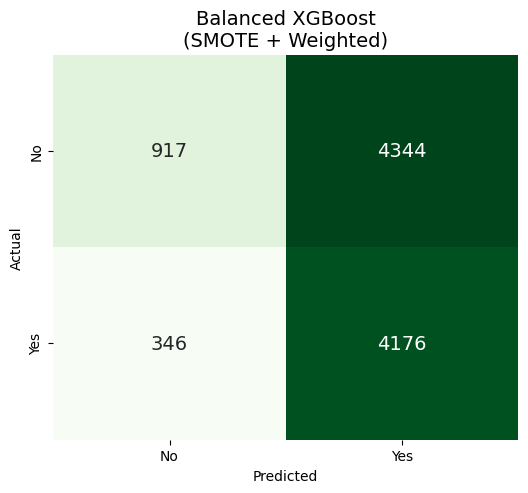


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.17      0.28      5261
           1       0.49      0.92      0.64      4522

    accuracy                           0.52      9783
   macro avg       0.61      0.55      0.46      9783
weighted avg       0.62      0.52      0.45      9783



In [12]:
# --- 0. INSTALL SMOTE ---
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Installing SMOTE...")
    !pip install -q imblearn
    from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# --- 1. APPLY SMOTE (FIXING THE RATIO) ---
print("Balancing Data with SMOTE...")
print(f"   Original Training Distribution: {np.bincount(y_train)}")

# Create synthetic "Readmitted" patients to make it 50/50
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"   New Balanced Distribution:      {np.bincount(y_train_resampled)}")
print("   (Now the model sees equal amounts of Yes and No!)")

# --- 2. TRAIN WEIGHTED XGBOOST ---
# scale_pos_weight estimate: Total Negatives / Total Positives
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"\nTraining XGBoost with scale_pos_weight={ratio:.2f}...")

# We use the SMOTE data AND the weight parameter for maximum effect
clf_balanced = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=ratio,  # Heavily penalize missing a Readmission
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

clf_balanced.fit(X_train_resampled, y_train_resampled)

# --- 3. EVALUATE ---
probs = clf_balanced.predict_proba(X_val)[:, 1]

# Find best threshold on the REAL validation set (never SMOTE the validation set!)
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.2, 0.8, 0.05):
    score = f1_score(y_val, (probs >= t).astype(int))
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"\nNew Balanced F1 Score: {best_f1:.4f} (Threshold: {best_thresh:.2f})")

# --- 4. PLOT NEW CONFUSION MATRIX ---
preds = (probs >= best_thresh).astype(int)
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={"size": 14})
plt.title(f"Balanced XGBoost\n(SMOTE + Weighted)", fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No', 'Yes'])
plt.yticks([0.5, 1.5], ['No', 'Yes'])
plt.show()

# --- 5. CLASSIFICATION REPORT ---
print("\nClassification Report:")
print(classification_report(y_val, preds))

#**GENERATE SUBMISSION & SAVE MODEL**

In [14]:
import joblib

# --- 1. Generate Predictions for Submission ---
# Use the Best Threshold we found (0.35)
test_probs = clf.predict_proba(X_test_final)[:, 1]
test_preds = (test_probs >= 0.35).astype(int)

# Load raw test data again just to get the IDs
test_raw_ids = pd.read_csv('test-1617360461595-1660719701431.csv')

# Create Submission DataFrame
submission = pd.DataFrame({
    'encounter_id': test_raw_ids['encounter_id'],
    'prediction': test_preds
})

# Save Submission
submission.to_csv('Final_Submission.csv', index=False)
print("'Final_Submission.csv' saved successfully!")

# --- 2. Save Model & Columns for Streamlit ---
# Save the model
joblib.dump(clf, 'model.pkl')

# CRITICAL: Save the column names.
# The app needs to know exactly which columns (and in what order) the model expects.
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("'model.pkl' and 'model_columns.pkl' saved!")
print(" Download these 3 files from the Files tab on the left.")

'Final_Submission.csv' saved successfully!
'model.pkl' and 'model_columns.pkl' saved!
 Download these 3 files from the Files tab on the left.
